In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.initializers import Constant
from sklearn.utils import shuffle
from tensorflow.keras.layers import Bidirectional, LSTM

from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler

In [ ]:
def min_max_scale(train_df,val_df,test_df):
    train_min = np.min(train_df,axis=0)
    train_max = np.max(train_df,axis=0)

    train_df = (train_df - train_min)/(train_max - train_min)
    val_df = (val_df - train_min) /(train_max - train_min)
    test_df = (test_df - train_min) /(train_max - train_min)

    return(train_df,val_df,test_df)

In [ ]:
def plot_series(time, series, prediction):
    start=0; end=None;
    plt.figure(figsize=(18,10))
    plt.plot(time[start:end], series[start:end], 
             label='Ground Truth')
    
    plt.plot(time[start:end], prediction[start:end],
             label='Prediction',
             linestyle='dashed')
    plt.xlabel("Time Step",fontsize=25)
    plt.ylabel("Value (mm)",fontsize=25)    
    plt.yticks(fontsize=16) 
    plt.xticks(fontsize=16)
    plt.grid(True)
    plt.legend(loc='upper left',fontsize='xx-large')

In [ ]:
#path = '/home/juan/Desktop/TESIS/Codes/codesTesis/Paso1/'
path = '/content/'
Dataset = pd.read_csv(path+'Rumipamba.csv',index_col=0)
#Dataset

Asign to $[1:24]$ time step $\sum [25:25+6]$ Value (mm)

In [ ]:
Data = Dataset.copy()
Data = Data.to_numpy()
X = []

label = Dataset["Value (mm)"].copy()
label = label.to_numpy()
y=[]


for i in range(0,len(Data)-108-1):
    left_top = np.matrix( Data[i:i+12])           # 1 hour step
    center_top = np.matrix( Data[i+12:i+24]) 
    right_top = np.matrix( Data[i+24:i+36]) 


    left_center = np.matrix( Data[i+36:i+48])
    center_center = np.matrix( Data[i+48:i+60]) 
    right_center = np.matrix( Data[i+60:i+72]) 

    left_bottom = np.matrix( Data[i+72:i+84])
    center_bottom = np.matrix( Data[i+84:i+96]) 
    right_bottom =  np.matrix( Data[i+96:i+108]) 
    

    #frame = [ [ 4 hours ago,  3 hours ago],
    #          [ 2 hours ago,  1 hour ago] ]

    frame = np.block([ [left_top,    center_top,    right_top],
                       [left_center, center_center, right_center],
                       [left_bottom, center_bottom,  right_bottom] ])

    X.append(frame)

    y.append(sum(label[i+108:i+108+6])) # now+ 30 mins

print(len(X))
print(len(y))

68099
68099


In [ ]:
print(X[-1].shape)

(36, 33)


In [ ]:
X = np.ndarray(shape = (len(X),36,33), buffer=np.array([X]) )
X.shape

(68099, 36, 33)

Scale the data

In [ ]:
n = len(X)
X_train = X[0:int(n*0.7)]
X_val = X[int(n*0.7):int(n*0.9)]
X_test = X[int(n*0.9):]

X_train,X_val,X_test = min_max_scale(X_train,X_val,X_test)

Y_train = np.array(y[0:int(n*0.7)])
Y_val = np.array(y[int(n*0.7):int(n*0.9)])
Y_test = np.array(y[int(n*0.9):])

In [ ]:
X_train, Y_train = shuffle(X_train,Y_train,random_state=13)
X_val, Y_val = shuffle(X_val,Y_val)

**Reshape the feature matrix to be convolutional ready as** 

$X =  [samples][timesteps][features][channel]$

$X =  [samples][pixels][width][channel]$

In [ ]:
X_train = X_train.reshape(X_train.shape[0],36,33, 1).astype('float32')
X_val = X_val.reshape(X_val.shape[0],36,33, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0],36,33, 1).astype('float32')

Build the model

In [ ]:
def convolutional_model():
  model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)])
  
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.0004),
                metrics=[tf.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.RootMeanSquaredError(),
                         tf.keras.metrics.MeanSquaredLogarithmicError()])  

  return model

In [ ]:
"""def convolutional_model():
  model = tf.keras.models.Sequential([
                                      
  tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), 
                               strides=(2, 2), padding="same",
                               activation = 'relu',
                               input_shape=(36, 33,1)),

  tf.keras.layers.TimeDistributed(
      tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                             strides=1, padding="causal",
                             activation="relu")),

  tf.keras.layers.TimeDistributed(
      tf.keras.layers.Flatten()),

  tf.keras.layers.TimeDistributed(
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))),
      
  tf.keras.layers.TimeDistributed(
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))),

  tf.keras.layers.TimeDistributed(
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))),
      
  tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()), 
      
  tf.keras.layers.Flatten(),      

  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)])
  
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.0004),
                metrics=[tf.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.RootMeanSquaredError(),
                         tf.keras.metrics.MeanSquaredLogarithmicError()])  

  return model"""

'def convolutional_model():\n  model = tf.keras.models.Sequential([\n                                      \n  tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), \n                               strides=(2, 2), padding="same",\n                               activation = \'relu\'),\n\n  tf.keras.layers.TimeDistributed(\n      tf.keras.layers.Conv1D(filters=128, kernel_size=3,\n                             strides=1, padding="causal",\n                             activation="relu")),\n\n  tf.keras.layers.TimeDistributed(\n      tf.keras.layers.Flatten()),\n\n  tf.keras.layers.TimeDistributed(\n      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))),\n      \n  tf.keras.layers.TimeDistributed(\n      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))),\n\n  tf.keras.layers.TimeDistributed(\n      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))),\n      \n  tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()), \n      \n  tf.

In [ ]:
model = convolutional_model()

In [ ]:
MAX_EPOCHS = 100

def compile_and_fit(model):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=10,
                                                    mode='min',
                                                    verbose=1)

  history = model.fit(X_train, Y_train, epochs=MAX_EPOCHS,
                    validation_data=(X_val,Y_val),
                    callbacks=[early_stopping])
  print(model.summary())
  return history

  #MeanAbsoluteError
  #RootMeanSquaredError

In [ ]:
history = compile_and_fit(model)

Epoch 1/100
1490/1490 [==============================] - 237s 135ms/step - loss: 1.2846 - mean_absolute_error: 0.7037 - root_mean_squared_error: 1.0919 - mean_squared_logarithmic_error: 0.1881 - val_loss: 0.4607 - val_mean_absolute_error: 0.2007 - val_root_mean_squared_error: 0.6788 - val_mean_squared_logarithmic_error: 0.0711
Epoch 2/100
1490/1490 [==============================] - 203s 136ms/step - loss: 0.4971 - mean_absolute_error: 0.2557 - root_mean_squared_error: 0.7029 - mean_squared_logarithmic_error: 0.0766 - val_loss: 0.4573 - val_mean_absolute_error: 0.2086 - val_root_mean_squared_error: 0.6763 - val_mean_squared_logarithmic_error: 0.0710
Epoch 3/100
1490/1490 [==============================] - 202s 136ms/step - loss: 0.3673 - mean_absolute_error: 0.1986 - root_mean_squared_error: 0.6049 - mean_squared_logarithmic_error: 0.0589 - val_loss: 0.4564 - val_mean_absolute_error: 0.2897 - val_root_mean_squared_error: 0.6755 - val_mean_squared_logarithmic_error: 0.0836
Epoch 4/100
1

In [ ]:
result = model.evaluate(X_test,Y_test)
dict(zip(model.metrics_names, result))

213/213 [==============================] - 12s 57ms/step - loss: 0.3478 - mean_absolute_error: 0.1733 - root_mean_squared_error: 0.5897 - mean_squared_logarithmic_error: 0.0448


{'loss': 0.3478015959262848,
 'mean_absolute_error': 0.1733112335205078,
 'mean_squared_logarithmic_error': 0.04475684091448784,
 'root_mean_squared_error': 0.5897470712661743}

Plots

In [ ]:
"""loss = history.history['loss']
zoom=0
epochs = range(zoom,len(loss))
plot_loss = loss[zoom:]
#print(plot_loss)
plt.figure(figsize=(8,8))
plt.plot(epochs, plot_loss, 'b')
plt.xlabel('Epochs \n ',fontsize=25)
plt.ylabel('Loss',fontsize=25)
#plt.title('Epochs vs Loss',fontsize=20)
plt.yticks(fontsize=16) 
plt.xticks(fontsize=16) 
#plt.savefig('/content/figs/Rumipamba_epoch_vs_loss.pdf', format='pdf')
plt.show()"""

"loss = history.history['loss']\nzoom=0\nepochs = range(zoom,len(loss))\nplot_loss = loss[zoom:]\n#print(plot_loss)\nplt.figure(figsize=(8,8))\nplt.plot(epochs, plot_loss, 'b')\nplt.xlabel('Epochs \n ',fontsize=25)\nplt.ylabel('Loss',fontsize=25)\n#plt.title('Epochs vs Loss',fontsize=20)\nplt.yticks(fontsize=16) \nplt.xticks(fontsize=16) \n#plt.savefig('/content/figs/Rumipamba_epoch_vs_loss.pdf', format='pdf')\nplt.show()"

In [ ]:
"""loss = history.history['loss']
zoom=1
epochs = range(zoom,len(loss))
plot_loss = loss[zoom:]
#print(plot_loss)
plt.figure(figsize=(8,8))
plt.plot(epochs, plot_loss, 'b')
plt.xlabel('Epochs',fontsize=25)
plt.ylabel('Loss',fontsize=25)
#plt.title('Epochs vs Loss',fontsize=20)
plt.yticks(fontsize=16) 
plt.xticks(fontsize=16) 
#plt.savefig('/content/figs/Rumipamba_epoch_vs_loss_zoom.pdf', format='pdf')
plt.show()"""

"loss = history.history['loss']\nzoom=1\nepochs = range(zoom,len(loss))\nplot_loss = loss[zoom:]\n#print(plot_loss)\nplt.figure(figsize=(8,8))\nplt.plot(epochs, plot_loss, 'b')\nplt.xlabel('Epochs',fontsize=25)\nplt.ylabel('Loss',fontsize=25)\n#plt.title('Epochs vs Loss',fontsize=20)\nplt.yticks(fontsize=16) \nplt.xticks(fontsize=16) \n#plt.savefig('/content/figs/Rumipamba_epoch_vs_loss_zoom.pdf', format='pdf')\nplt.show()"

In [ ]:
"""pred = model.predict(X_test)
prediction = []
for i in range(len(pred)):
  if pred[i] <0:
    prediction.append(pred[i]*pred[i])
  else:
    prediction.append(pred[i]*1.5)
  if prediction[-1]<0.05:
     prediction[-1]=0"""

'pred = model.predict(X_test)\nprediction = []\nfor i in range(len(pred)):\n  if pred[i] <0:\n    prediction.append(pred[i]*pred[i])\n  else:\n    prediction.append(pred[i]*1.5)\n  if prediction[-1]<0.05:\n     prediction[-1]=0'

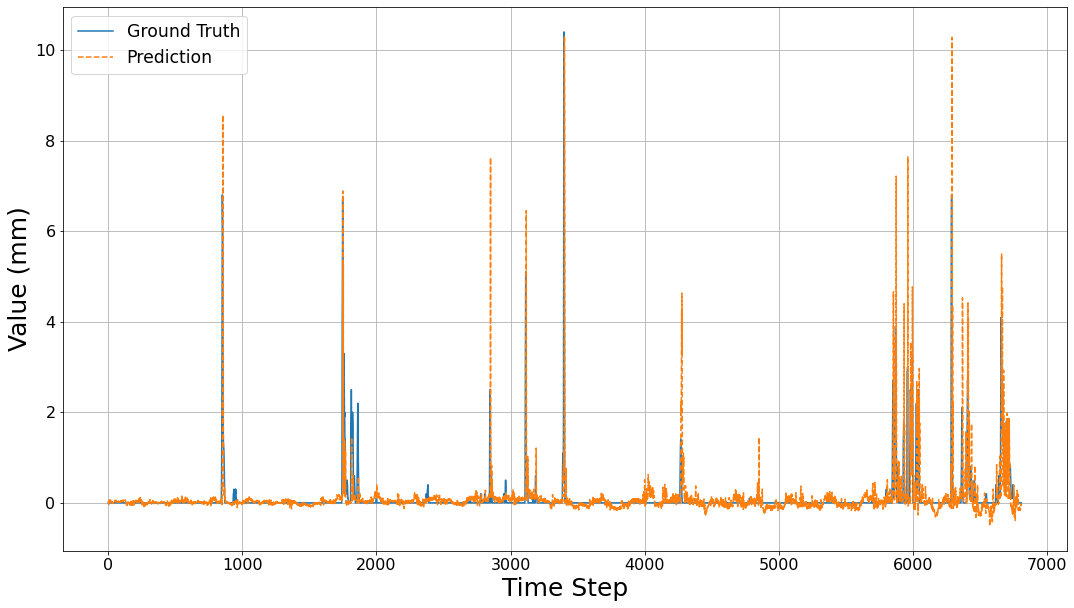

In [ ]:
prediction = model.predict(X_test)

#plt.title('Prediction vs Real Value',fontsize=20)

plot_series(range(len(Y_test)),Y_test, prediction)
#plt.savefig('/content/figs/Rumipamba_4h_input_sum_6_step_out_prediction.pdf', format='pdf')

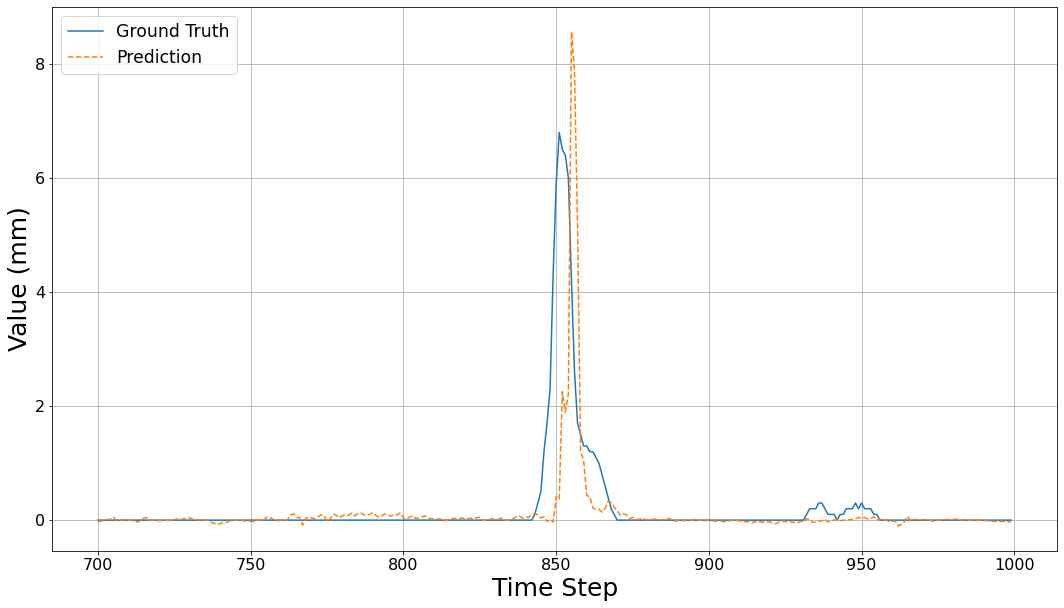

In [ ]:
#plt.title('Zoomed Prediction vs Real Value',fontsize=20)

start=700
end=1000

time = [i for i in range(start,end)]

plot_series((time), Y_test[start:end],prediction[start:end])
#plt.savefig('/content/figs/Rumipamba_4h_input_sum_6_step_out_prediction_zoom1.pdf', format='pdf')

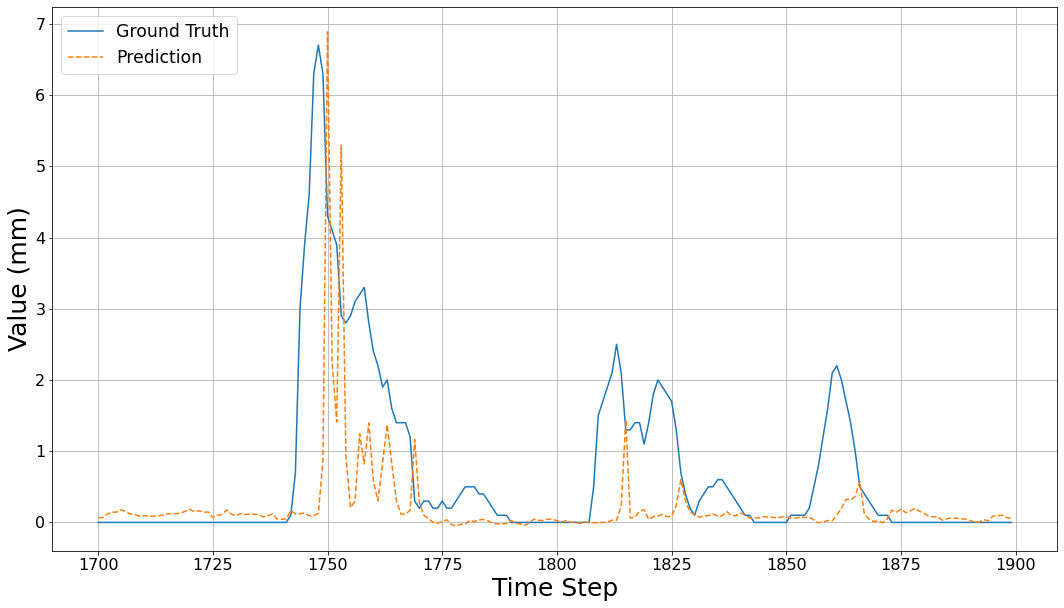

In [ ]:
start=1700
end=1900

time = [i for i in range(start,end)]

plot_series((time), Y_test[start:end],prediction[start:end])
#plt.savefig('/content/figs/Rumipamba_4h_input_sum_6_step_outprediction_zoom2.pdf', format='pdf')

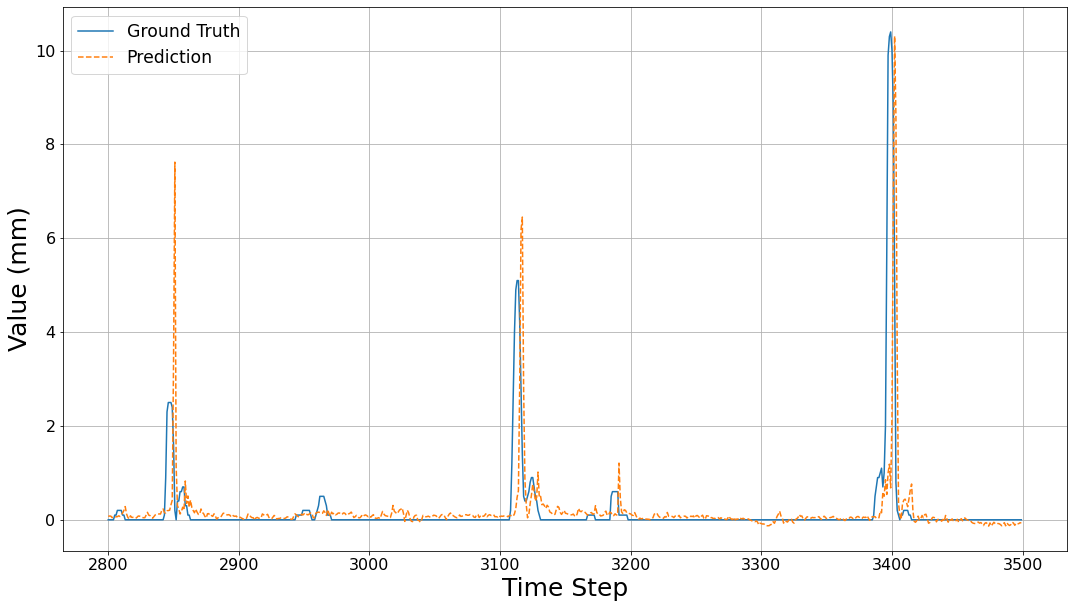

In [ ]:
#plt.title('Zoomed Prediction vs Real Value',fontsize=20)

start=2800
end=3500

time = [i for i in range(start,end)]

plot_series((time), Y_test[start:end],prediction[start:end])
#plt.savefig('/content/figs/Rumipamba_4h_input_sum_6_step_out_prediction_zoom3.pdf', format='pdf')

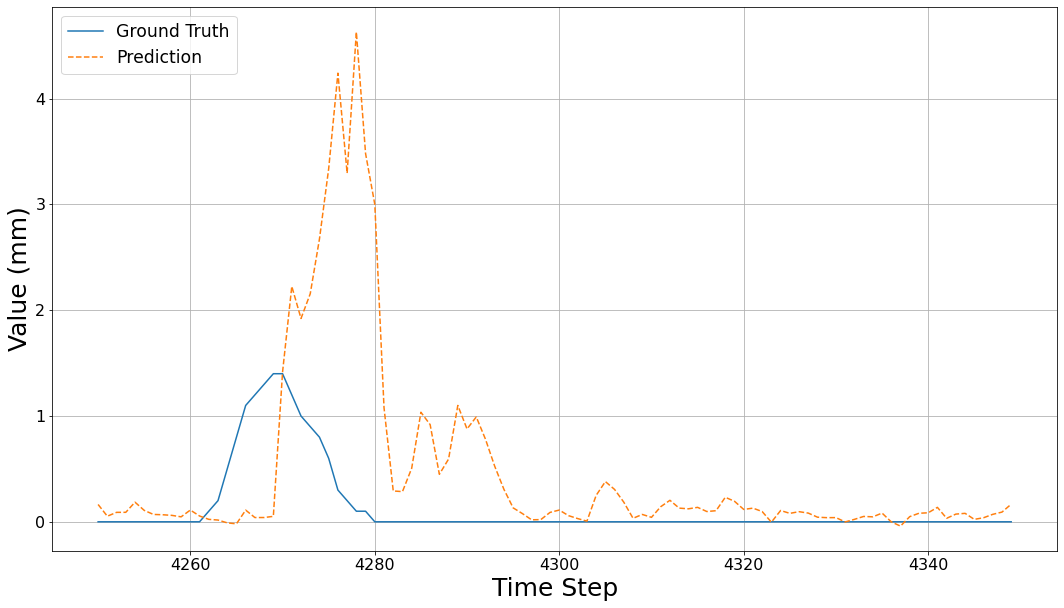

In [ ]:
#plt.title('Zoomed Prediction vs Real Value',fontsize=20)

start=4250
end=4350

time = [i for i in range(start,end)]

plot_series((time), Y_test[start:end],prediction[start:end])
#plt.savefig('/content/figs/Rumipamba_4h_input_sum_6_step_out_prediction_zoom4.pdf', format='pdf')

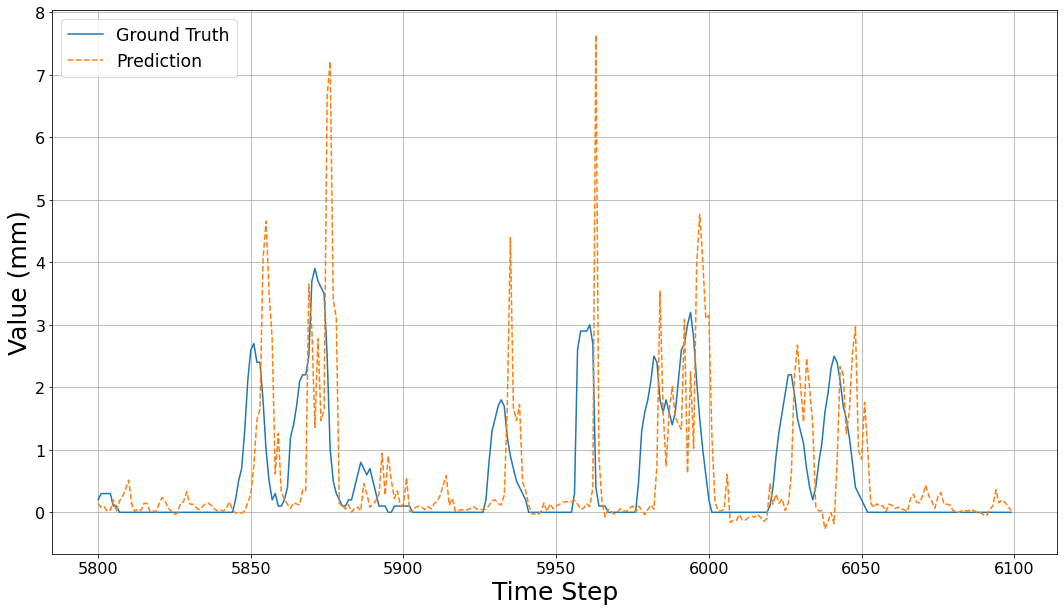

In [ ]:
#plt.title('Zoomed Prediction vs Real Value',fontsize=20)

start=5800
end=6100

time = [i for i in range(start,end)]

plot_series((time), Y_test[start:end],prediction[start:end])
#plt.savefig('/content/figs/Rumipamba_4h_input_sum_6_step_out_prediction_zoom5.pdf', format='pdf')

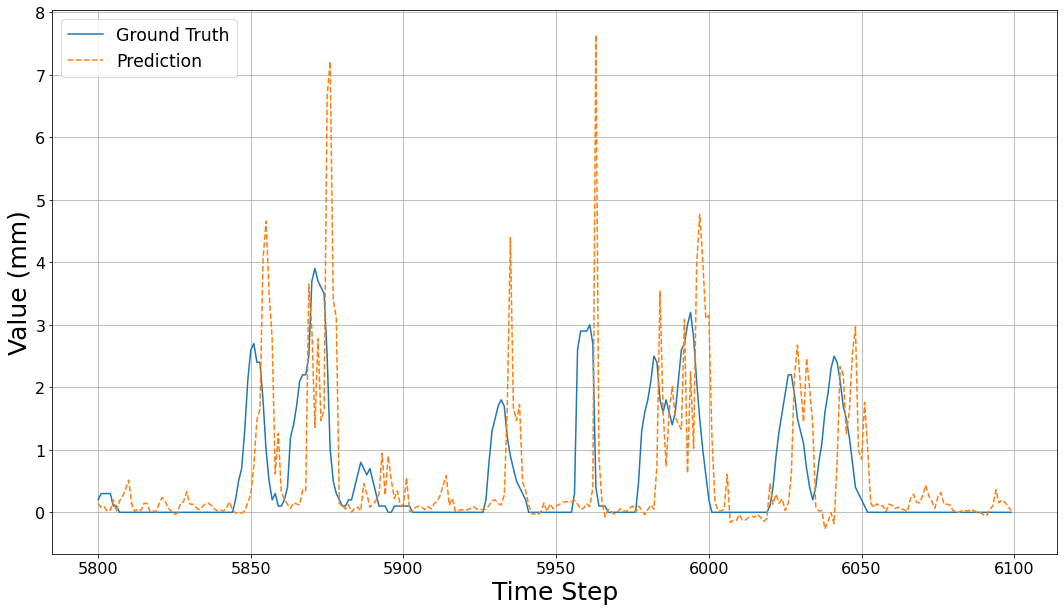

In [ ]:
#plt.title('Zoomed Prediction vs Real Value',fontsize=20)

start=5800
end=6100

time = [i for i in range(start,end)]

plot_series((time), Y_test[start:end],prediction[start:end])
#plt.savefig('/content/figs/Rumipamba_4h_input_sum_6_step_out_prediction_zoom6.pdf', format='pdf')

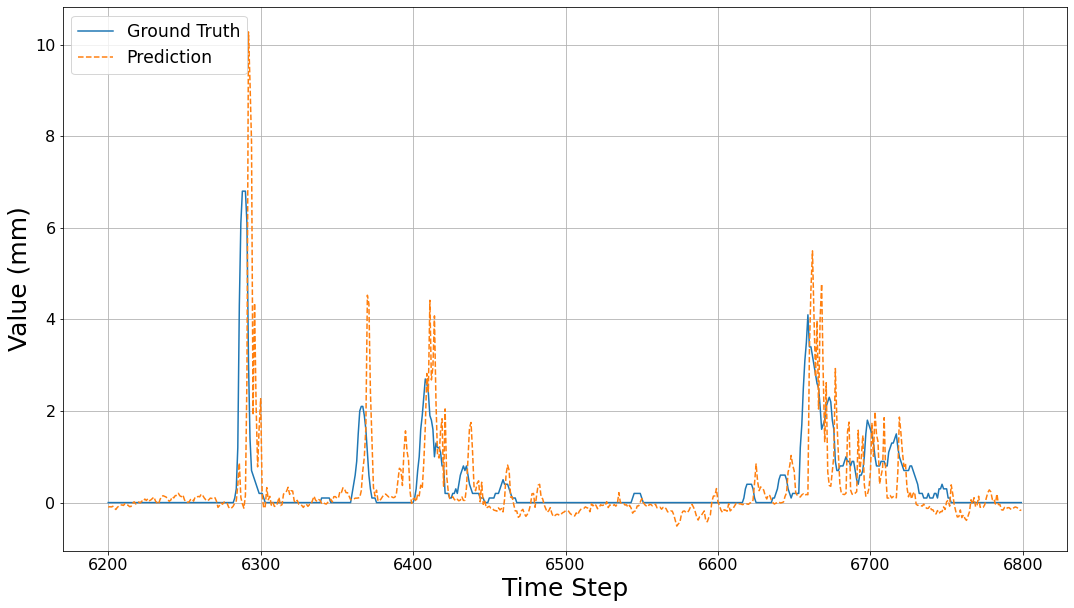

In [ ]:
#plt.title('Zoomed Prediction vs Real Value',fontsize=20)

start=6200
end=6800

time = [i for i in range(start,end)]

plot_series((time), Y_test[start:end],prediction[start:end])
#plt.savefig('/content/figs/Rumipamba_4h_input_sum_6_step_out_zoom7.pdf', format='pdf')

In [ ]:
#!zip -r figs.zip /content/figs/

In [ ]:
#model.save('model_Rumipamba_4h_input_sum_6_step_out.h5')
#new_model = tf.keras.models.load_model('my_model.h5') #same file path

In [ ]:
#model.save('model_Rumipamba_4h_input_sum_6_step_out')

#!zip -r model_Rumipamba_4h_input_sum_6_step_out.zip /content/model_Rumipamba_4h_input_sum_6_step_out/

#model = keras.models.load_model('path/to/location')